In [1]:
#import psycopg2
import os
import json
import csv
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier

import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics

Plan:
1) Data Collection
    - prase the JSON files
    - collect frames where there is only 1 person and the dance style is either ballet or tap
2) Feature Extraction
    - we have 17 keypoint coordinates we are looking at:
        - nose, R/L eye, R/L ear, R/L shoulder, R/L elbow, R/L wrist, R/L hip, R/L knee, R/L ankle
        - these coordinates will serve as our input data
3) Split the data into train/validation/test sets
4) Model
    - classification model

In [2]:
directory = '../Data/densepose/txt'

#get directories without hidden files
directories = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
directories.sort()

#Setup dictionary to collect file names
all_file_names = {}

#Identify all file names
for d in directories:
    #get file names without hidden files
    files = [f for f in os.listdir(os.path.join(directory, d)) if os.path.isfile(os.path.join(directory, d, f))]
    files.sort()
    all_file_names[d] = files

Function: Number of people in a frame

In [3]:
def person_count(file_name):
    '''Input a JSON file and get the number of people in each frame. '''
    f = open(file_name, "r")
    j = json.load(f)
    f.close

    people_count = len(j)

    return people_count

In [4]:
# Testing results, should return 5
peeps = person_count('../Data/densepose/txt/ballet/-5Yp-vToI2E_016_0001.json')
peeps

5

Extract frames where the dance type is 'ballet' or 'tap' and there is just 1 person in the frame.

In [5]:
def person_count(file_name):
    '''Input a JSON file and get the number of people in each frame. '''
    f = open(file_name, "r")
    j = json.load(f)
    f.close

    people_count = len(j)

    return people_count

In [6]:
# Setup lists to collect file paths
selected_files_ballet = []
selected_files_tap = []
selected_files_latin = []

# Identify all file names
for d in directories:
    if d == 'ballet':
        # Get file names without hidden files
        files = [f for f in os.listdir(os.path.join(directory, d)) if os.path.isfile(os.path.join(directory, d, f))]
        files.sort()
        for file_name in files:
            file_path = os.path.join(directory, d, file_name)
            # Count people in each frame
            num_people = person_count(file_path)
            if num_people == 1:  # Check if there is only one person
                selected_files_ballet.append(file_path)
    elif d == 'tap':
        # Get file names without hidden files
        files = [f for f in os.listdir(os.path.join(directory, d)) if os.path.isfile(os.path.join(directory, d, f))]
        files.sort()
        for file_name in files:
            file_path = os.path.join(directory, d, file_name)
            # Count people in each frame
            num_people = person_count(file_path)
            if num_people == 1:  # Check if there is only one person
                selected_files_tap.append(file_path)
    elif d == 'latin':
        # Get file names without hidden files
        files = [f for f in os.listdir(os.path.join(directory, d)) if os.path.isfile(os.path.join(directory, d, f))]
        files.sort()
        for file_name in files:
            file_path = os.path.join(directory, d, file_name)
            # Count people in each frame
            num_people = person_count(file_path)
            if num_people == 1:  # Check if there is only one person
                selected_files_latin.append(file_path)

# Print the sizes of the selected files lists
print("Number of selected files for ballet:", len(selected_files_ballet))
print("Number of selected files for tap:", len(selected_files_tap))
print("Number of selected files for tap:", len(selected_files_latin))

Number of selected files for ballet: 8351
Number of selected files for tap: 7078
Number of selected files for tap: 5355


In [7]:
print(selected_files_ballet[0])
print(selected_files_tap[0])
print(selected_files_latin[0])

../Data/densepose/txt/ballet/-sEgjXxjxIw_102_0026.json
../Data/densepose/txt/tap/-ZxOm8B-BX4_020_0001.json
../Data/densepose/txt/latin/01f-oLGZv1s_017_0004.json


In [8]:
def get_body_position_info(file_name):
    '''Input a JSON file and get the body position of each person.  Outer list is
    list of people.  Inner list is x,y position of each body part for that person'''
    f = open(file_name, "r")
    j = json.load(f)
    f.close
    people= []

    for i,person in enumerate(j):
        #Set up list to collect person's body location
        person_i = []
        count = 0

        #add each body part position to the list
        for body_part in person:
            count+=1
            if count == 1: continue
            else: person_i.append(body_part[1])

        #Append entire list to list of people
        people.append(person_i)

    return people

In [9]:
def get_body_part_labels(file_name):
    '''Input a JSON file and get the body position of each person.  Outer list is
    list of people.  Inner list is x,y position of each body part for that person'''
    f = open(file_name, "r")
    j = json.load(f)
    f.close()
    
    # Extract body part labels from the first person entry in the JSON file
    body_part_labels = [body_part[0] for body_part in j[0][1:]]
   
    return body_part_labels

**Creating Feature Map**

In [125]:
# Concatenate the lists of selected files for ballet and tap dance styles
all_selected_files = selected_files_ballet + selected_files_tap + selected_files_latin

# Split data into training and testing sets
train_files, test_files = train_test_split(all_selected_files, test_size=0.2, random_state=42)

# Initialize lists to store feature data and corresponding labels
train_feature_data = []
train_feature_data_flattened = []

train_labels = []

# Iterate through each JSON file representing a frame in the training set
for file_path in train_files:
    # Get body position info for the single person in the frame
    body_positions = get_body_position_info(file_path)
    
    train_feature_data.append(body_positions)

    # Flatten the list of x, y positions
    flattened_positions = [coord for point in body_positions for coord in point]
    
    # Append the flattened positions to the feature data list
    train_feature_data_flattened.append(flattened_positions)
    
    # Determine the label based on the file path (e.g., ballet or tap)
    if file_path in selected_files_ballet:
        label = 'ballet'
    elif file_path in selected_files_tap:
        label = 'tap'
    elif file_path in selected_files_latin:
        label = 'latin'
    else:
        label = 'unknown'
    train_labels.append(label)

# Convert the training feature data and labels into numpy arrays
X_train = np.array(train_feature_data)
X_train_flattened = np.array(train_feature_data_flattened)
y_train = np.array(train_labels)

print("Number of frames (rows) in X_train:", len(X_train_flattened))
print("Number of features (columns) in X_train:", len(X_train_flattened[0]))
print("Number of labels in y_train:", len(y_train))

Number of frames (rows) in X_train: 16627
Number of features (columns) in X_train: 17
Number of labels in y_train: 16627


In [126]:
# Initialize lists to store feature data and corresponding labels for the testing set
test_feature_data = []
test_feature_data_flattened = []
test_labels = []

# Iterate through each JSON file representing a frame in the testing set
for file_path in test_files:
    # Get body position info for the single person in the frame
    body_positions = get_body_position_info(file_path)
    
    test_feature_data.append(body_positions)
    
    # Flatten the list of x, y positions
    flattened_positions = [coord for point in body_positions for coord in point]
    
    # Append the flattened positions to the feature data list for the testing set
    test_feature_data_flattened.append(flattened_positions)

     # Determine the label based on the file path (e.g., ballet or tap)
    if file_path in selected_files_ballet:
        label = 'ballet'
    elif file_path in selected_files_tap:
        label = 'tap'
    elif file_path in selected_files_latin:
        label = 'latin'
    else:
        label = 'unknown'
    test_labels.append(label)

# Convert the testing feature data and labels into numpy arrays
X_test = np.array(test_feature_data)
X_test_flattened = np.array(test_feature_data_flattened)
y_test = np.array(test_labels)

print("Number of frames (rows) in X_test:", len(X_test_flattened))
print("Number of features (columns) in X_test:", len(X_test_flattened[0]))
print("Number of labels in y_test:", len(y_test))


Number of frames (rows) in X_test: 4157
Number of features (columns) in X_test: 17
Number of labels in y_test: 4157


In [12]:
# Define the body part labels
body_part_labels = [
    "nose_x", "nose_y", 
    "left_eye_x", "left_eye_y", 
    "right_eye_x", "right_eye_y", 
    "left_ear_x", "left_ear_y", 
    "right_ear_x", "right_ear_y", 
    "left_shoulder_x", "left_shoulder_y", 
    "right_shoulder_x", "right_shoulder_y", 
    "left_elbow_x", "left_elbow_y", 
    "right_elbow_x", "right_elbow_y", 
    "left_wrist_x", "left_wrist_y", 
    "right_wrist_x", "right_wrist_y", 
    "left_hip_x", "left_hip_y", 
    "right_hip_x", "right_hip_y", 
    "left_knee_x", "left_knee_y", 
    "right_knee_x", "right_knee_y", 
    "left_ankle_x", "left_ankle_y", 
    "right_ankle_x", "right_ankle_y"
]

# Create a dictionary to map body part labels to column indices
body_part_mapping = {label: i for i, label in enumerate(body_part_labels)}

# Access the x-coordinate of the left eye for all frames
left_eye_x_coordinates = X_train_flattened[:, body_part_mapping["left_eye_x"]]
print(left_eye_x_coordinates)
print(len(left_eye_x_coordinates))

# Access the y-coordinate of the right shoulder for all frames
right_shoulder_y_coordinates = X_train_flattened[:, body_part_mapping["right_shoulder_y"]]
# print(right_shoulder_y_coordinates)
print(len(right_shoulder_y_coordinates))

# Access both x and y coordinates of the nose for all frames
nose_coordinates = X_train_flattened[:, [body_part_mapping["nose_x"], body_part_mapping["nose_y"]]]
# print(nose_coordinates)
print(len(nose_coordinates))

[[ 547.86218262  136.1907196 ]
 [ 920.58422852  560.0927124 ]
 [ 807.80541992  138.15003967]
 ...
 [1033.99133301  581.4720459 ]
 [ 879.79620361  465.55227661]
 [1060.29284668  316.88543701]]
16627
16627
16627


In [13]:
df_train = pd.DataFrame(X_train.reshape(X_train.shape[0], -1), columns=body_part_labels)
df_train['label'] = y_train
df_train

,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,...,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,label
0,558.831970,152.176117,563.818237,137.189819,547.862183,136.190720,489.024231,136.190720,499.994019,136.190720,...,424.926941,647.587524,505.852997,564.815491,515.843872,654.568298,648.722473,572.793518,663.708801,latin
1,927.572021,561.091858,872.668091,580.075012,920.584229,560.092712,867.676880,582.073242,867.676880,583.072327,...,780.896973,1036.381470,872.815491,844.717041,864.822571,1063.334351,999.703064,848.710083,999.703064,ballet
2,818.796265,150.146713,817.797119,139.149765,807.805420,138.150040,817.797119,151.146439,775.832092,152.146149,...,378.083527,790.819641,534.040283,636.947937,532.040833,739.862122,655.006775,589.987061,661.005127,tap
3,615.400635,211.595520,625.389465,193.617249,606.410645,194.616043,652.359375,176.637756,675.333740,168.647415,...,364.410919,628.386108,463.291443,719.284668,458.297485,597.420715,561.173218,671.338196,552.184082,latin
4,833.528931,236.255890,851.501282,223.265137,821.547363,222.265839,886.447632,232.258728,807.568787,225.263702,...,539.040466,1003.268127,704.922485,814.558105,749.890503,1091.133057,883.795227,833.528931,914.773193,tap
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16622,696.792847,130.756470,709.787048,121.760094,683.798584,119.760902,720.782166,134.754852,661.808350,125.758484,...,345.669708,646.815002,501.606781,543.860718,479.615662,668.805237,648.547485,464.895752,604.565247,tap
16623,959.969849,185.541992,977.959167,171.553864,945.978210,170.554703,995.948425,160.563187,918.994263,170.554703,...,459.309540,1026.929932,612.179749,946.977600,627.167053,994.949036,770.045715,922.991882,790.028748,tap
16624,1026.991577,579.472473,1026.991577,515.486511,1033.991333,581.472046,1016.991760,435.503998,1018.991760,432.504669,...,654.456055,1003.992126,803.423462,838.996094,805.423035,1009.991943,948.391724,778.997559,944.392578,ballet
16625,884.795166,482.533386,904.791077,465.552277,879.796204,465.552277,942.783386,460.557831,867.798645,462.555603,...,738.248901,698.833008,844.131104,698.833008,842.133301,607.851562,1002.954407,1105.750244,978.981079,ballet


**Model**

X (feature matrix): 
- the x,y positions of the different body parts for each frame in our dataset
- each row in the matrix corresponds to one frame
- each column represents either the x or y position of a specific body part
- there are a total of 17 attributes - nose, R/L eye, R/L ear, R/L shoulder, R/L elbow, R/L wrist, R/L hip, R/L knee, R/L ankle 
- our matrix has a total of 34 columns (17x2 for each x,y coordinate)
- our matrix has a total of 15429 rows (8351 ballet frames; 7078 tap frames)

Y (target variable)
- represents the output label, in our case the dance style associated with each frame (ballet OR tap)

## Add Scaling and Normalization

#### Plan:

- treat the center of the left and right hip as the "body center"
    - scale all data positions relative to this center
- Find the bounding box around each person (max width and height)
    - Normalize based on the respective width and height
        -divide by width for x, divide by height for y
- Alternative normalization is dividing by the distance between hips

In [48]:
#Create dictionary for unseparated body part mapping
body_part_labels_unseparated = get_body_part_labels('../Data/densepose/txt/ballet/-5Yp-vToI2E_016_0001.json')
body_part_indx_dict = {}
body_part_mapping_unseparated = {label: i for i, label in enumerate(body_part_labels_unseparated)}
body_part_mapping_unseparated

{'nose': 0,
 'left_eye': 1,
 'right_eye': 2,
 'left_ear': 3,
 'right_ear': 4,
 'left_shoulder': 5,
 'right_shoulder': 6,
 'left_elbow': 7,
 'right_elbow': 8,
 'left_wrist': 9,
 'right_wrist': 10,
 'left_hip': 11,
 'right_hip': 12,
 'left_knee': 13,
 'right_knee': 14,
 'left_ankle': 15,
 'right_ankle': 16}

Note: normalize_frame will normalize distance by hip distance in x-axis.  Normalize_frame_by_box will calculate the width and length and normalize by those values respectively.

In [166]:
 def normalize_frame(X_frame): 
    '''Input a frame of dimensions (1,17,2) that contains X and Y information.
    Will return normalized x and y data relative to hip position, normalized
    by hip width'''

    #Pull out x and y values from the frame
    x_values = X_frame[0,:,0]
    y_values = X_frame[0,:,1]

    #Identify hip information.  Calculate the center of the hip for x and y values
    left_hip_x = x_values[body_part_mapping_unseparated['left_hip']]
    right_hip_x = x_values[body_part_mapping_unseparated['right_hip']]
    hip_distance_x = abs(left_hip_x - right_hip_x)
    hip_center_x = min(left_hip_x,right_hip_x) + hip_distance_x/2

    #For cases when there is no distance between hips
    if hip_distance_x == 0:
       return None, hip_distance_x

    left_hip_y = y_values[body_part_mapping_unseparated['left_hip']]
    right_hip_y = y_values[body_part_mapping_unseparated['right_hip']]
    hip_center_y = min(left_hip_y,right_hip_y) + abs(left_hip_y - right_hip_y)/2

    #Center based on hip center and normalized based on hip distance
    x_values_new = (x_values - hip_center_x)/hip_distance_x
    y_values_new = (y_values - hip_center_y)/hip_distance_x

    #Stack the data back into one array of shape (1,17,2)
    normalized_frame = np.stack((x_values_new, y_values_new), axis=-1).reshape(1,17,2)
    return normalized_frame, hip_distance_x

 def normalize_frame_by_box(X_frame): 
    '''Input a frame of dimensions (1,17,2) that contains X and Y information.
    Will return normalized x and y data relative to hip position, normalized
    by hip width'''

    #Pull out x and y values from the frame
    x_values = X_frame[0,:,0]
    y_values = X_frame[0,:,1]

    #Identify hip information.  Calculate the center of the hip for x and y values
    left_hip_x = x_values[body_part_mapping_unseparated['left_hip']]
    right_hip_x = x_values[body_part_mapping_unseparated['right_hip']]
    hip_distance_x = abs(left_hip_x - right_hip_x)
    hip_center_x = min(left_hip_x,right_hip_x) + hip_distance_x/2
    width = max(x_values) - min(x_values)

    left_hip_y = y_values[body_part_mapping_unseparated['left_hip']]
    right_hip_y = y_values[body_part_mapping_unseparated['right_hip']]
    hip_center_y = min(left_hip_y,right_hip_y) + abs(left_hip_y - right_hip_y)/2
    height = max(y_values) - min(y_values)

    #Center based on hip center and normalized based on hip distance
    x_values_new = (x_values - hip_center_x)/width
    y_values_new = (y_values - hip_center_y)/height

    #Stack the data back into one array of shape (1,17,2)
    normalized_frame = np.stack((x_values_new, y_values_new), axis=-1).reshape(1,17,2)
    return normalized_frame, hip_distance_x


def normalize_data(X_data):
    '''Input a dataset of dimensions (n,1,17,2) that contains X and Y information.
    Will return normalized x and y data relative to hip position, normalized
    by hip width'''

    #Set up emtpy array
    normalized_data = np.empty((0,1,17,2))
    hip_distances = []
    frames_to_drop = []

    #Populate the array with normalized data
    for i in range(len(X_data)):
        new_row, hip_distance = normalize_frame_by_box(X_train[i])
        if new_row is not None:
            new_row = new_row.reshape(1,1,17,2)
            normalized_data = np.concatenate((normalized_data, new_row), axis = 0)
            hip_distances.append(hip_distance)
        else:
            frames_to_drop.append(i)

    return normalized_data, hip_distances,frames_to_drop

X_train_normalized, hip_distances, frames_to_drop_train = normalize_data(X_train)
X_train_normalized_flattened = X_train_normalized.reshape(X_train_normalized.shape[0],-1)

X_test_normalized, hip_distances_test, frames_to_drop_test = normalize_data(X_test)
X_test_normalized_flattened = X_test_normalized.reshape(X_test_normalized.shape[0],-1)

y_train_normalized = np.delete(y_train, frames_to_drop_train)
y_test_normalized = np.delete(y_test, frames_to_drop_test)
print(f'Train normalized data shape is {X_train_normalized_flattened.shape}')
print(f'Test normalized data shape is {X_test_normalized_flattened.shape}')
print(f'Train normalized labels shape is {y_train_normalized.shape}')
print(f'Test normalized labels shape is {y_test_normalized.shape}')

Train normalized data shape is (16627, 34)
Test normalized data shape is (4157, 34)
Train normalized labels shape is (16627,)
Test normalized labels shape is (4157,)


Note: Lost a few frames because the hip distances were exactly = 0

1115.6988525390625

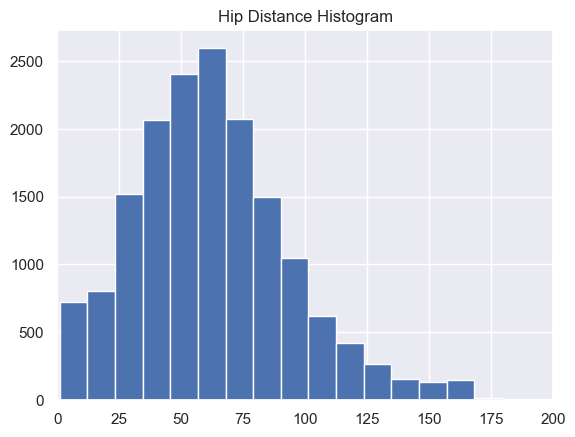

In [154]:
plt.hist(hip_distances, bins=100)
plt.xlim(0,200)
plt.title('Hip Distance Histogram')

In [115]:
#Flatten original data
X_train_flattened_reshaped = X_train_flattened.reshape(X_train_flattened.shape[0], -1)
X_test_flattened_reshaped = X_test_flattened.reshape(X_test_flattened.shape[0], -1)
print(X_train_flattened_reshaped.shape)
print(X_test_flattened_reshaped.shape)
print(y_train.shape)
print(y_test.shape)

(16627, 34)
(4157, 34)
(16627,)
(4157,)


In [130]:
# Original Data
# Initialize the Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train_flattened_reshaped, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test_flattened_reshaped)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9562184267500602


In [167]:
#Normalized Data
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_normalized_flattened, y_train_normalized)
y_pred = model.predict(X_test_normalized_flattened)
accuracy = accuracy_score(y_test_normalized, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.3488092374308395


## Analyze the results from the Random Forest Model

Goal:
- Evaluate the confusion matrix
- Identify the specific classes with the most mistakes
- Visually observe images from the misidentified classes to look for obvious trends

#### Setup plotting functions

In [21]:
def get_body_part_labels(file_name):
    '''Input a JSON file and get the body position of each person.  Outer list is
    list of people.  Inner list is x,y position of each body part for that person'''
    f = open(file_name, "r")
    j = json.load(f)
    f.close
    body_part_labels= []
   
    for i,body_part in enumerate(j[0]):
            if i == 0: continue
            else: body_part_labels.append(body_part[0])

    return body_part_labels

def plot_body_positions_eval(list_of_people, figsize = (8,4), ax=None):

    #If not ax input, then just make a figure
    if ax == None:
        plt.figure(figsize=figsize)
        ax = plt.gca()

    cmap = plt.colormaps.get_cmap('tab10').colors*2 #*2 for when there's >10 ppl/image
    #cmap = cmap + cmap # Get the tab10 colormap
    for i,person in enumerate(list_of_people):
        #separate x and y information into lists
        x_values = [point[0] for point in person]
        y_values = [point[1] for point in person]
        y_values = [800 - i for i in y_values] #Invert x due to skeleton data structure

        #Plot the connections between joints
        for k,v in connections_dict.items():
            temp_x = [x_values[body_part_indx_dict[k]], x_values[body_part_indx_dict[v]]]
            temp_y = [y_values[body_part_indx_dict[k]], y_values[body_part_indx_dict[v]]]
            ax.plot(temp_x, temp_y, linewidth=4, color=cmap[i])

        #Plot the scatter data and label figure
        ax.scatter(x_values, y_values, label=f'Person {i}', color=cmap[i])
    return ax

def plot_sample_frames(frame_indexes, file_list, true_label = None, pred_label = None, figsize = (15,3)):
    '''Input an index of 5 frames that you want to see in visual form for evaluation.  Include
    the file list (can be training data or test data) to provide file name innformation'''
    #Only accept 5 frames
    if len(frame_indexes) > 5:
        frame_indexes = frame_indexes[0:5]
    
    #Set up the plot
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=figsize)
    for i in range(5):
        frame_num = frame_indexes[i]
        frame = file_list[frame_num]
        toy_person = get_body_position_info(frame)
        plot_body_positions_eval(toy_person, figsize=(2, 2), ax=axs[i])
        axs[i].set_title(f'True: {true_label} \n Prediction: {pred_label}')
        axs[i].axis('off')
    plt.show()

#Get body part labels
body_part_labels = get_body_part_labels('../Data/densepose/txt/ballet/-5Yp-vToI2E_016_0001.json')

#Create body part index dictionary for easy acces to index of each body part
body_part_indx_dict = {}
indexes = list(range(len(body_part_labels)))
for i in range(len(body_part_labels)):
    body_part_indx_dict[body_part_labels[i]] = indexes[i]

#Hardcode dictionary of connections:
connections_dict = {}
connections_dict['left_shoulder'] = 'left_elbow'
connections_dict['left_elbow'] = 'left_wrist'
connections_dict['left_hip'] = 'left_knee'
connections_dict['left_knee'] = 'left_ankle'
connections_dict['right_shoulder'] = 'right_elbow'
connections_dict['right_elbow'] = 'right_wrist'
connections_dict['right_hip'] = 'right_knee'
connections_dict['right_knee'] = 'right_ankle'
connections_dict['left_ear'] = 'left_eye'
connections_dict['left_eye'] = 'nose'
connections_dict['nose'] = 'right_eye'
connections_dict['right_eye'] = 'right_ear'

In [22]:
#Preprocess the y data to be integers instead of strings
label_encoder = LabelEncoder()
y_pred_encoded = label_encoder.fit_transform(y_pred)
y_test_encoded = label_encoder.fit_transform(y_test)

#Collect label names
label_names = list(label_encoder.classes_)

#### Confustion Matrix

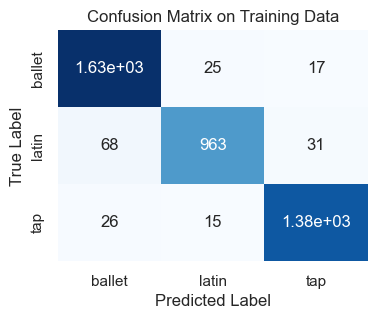

In [23]:
# Create confusion matrix on the training data
confusion_matrix = tf.math.confusion_matrix(y_test_encoded, y_pred_encoded)

# Use a heatmap plot to display it.
plt.figure(figsize=(4, 3))
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=label_names, yticklabels=label_names, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
ax.set_title('Confusion Matrix on Training Data')
plt.show()

#### Plot out and observe some mistaken frames

In [24]:
#Pull the index number from the label encoder (0,1,2, etc.)
ballet_index = np.where(label_encoder.classes_== 'ballet')[0][0]
latin_index = np.where(label_encoder.classes_== 'latin')[0][0]
tap_index = np.where(label_encoder.classes_== 'tap')[0][0]

#identify indexes of false positives and false negatives
#Only keep the first 5 from the list
latin_to_ballet_index = np.where((y_pred_encoded == ballet_index) & (y_test_encoded == latin_index))[0]
latin_to_tap_index = np.where((y_pred_encoded == tap_index) & (y_test_encoded == latin_index))[0]

#Identify indexes of properly identified people
ballet_to_ballet_index = np.where((y_pred_encoded == ballet_index) & (y_test_encoded == ballet_index))[0]
latin_to_latin_index = np.where((y_pred_encoded == latin_index) & (y_test_encoded == latin_index))[0]

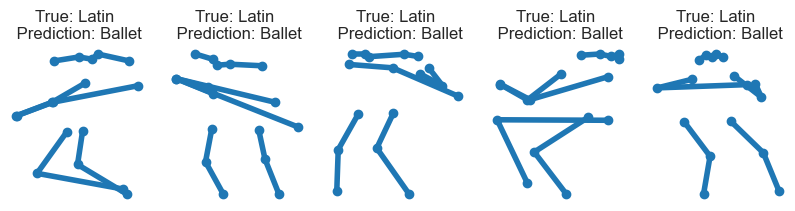

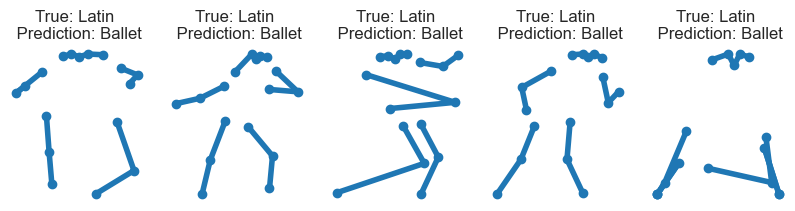

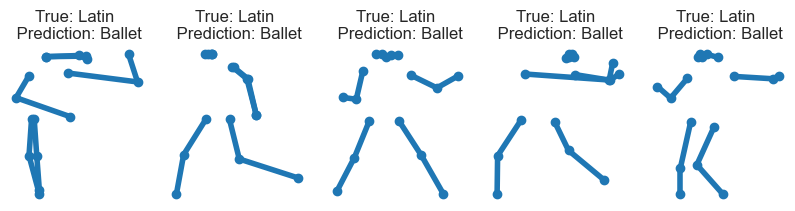

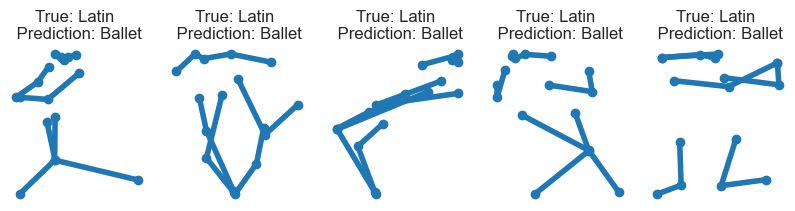

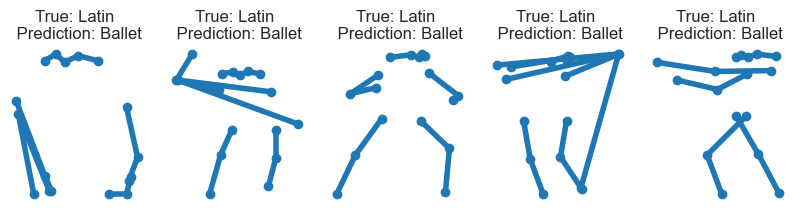

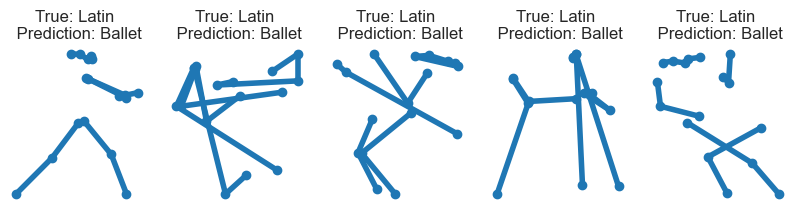

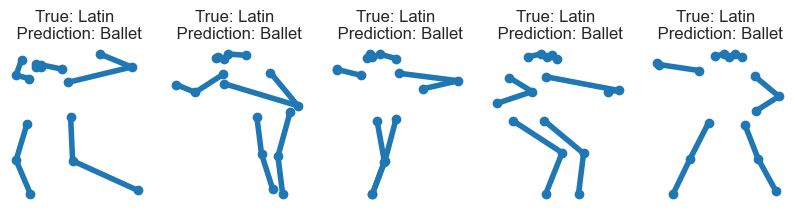

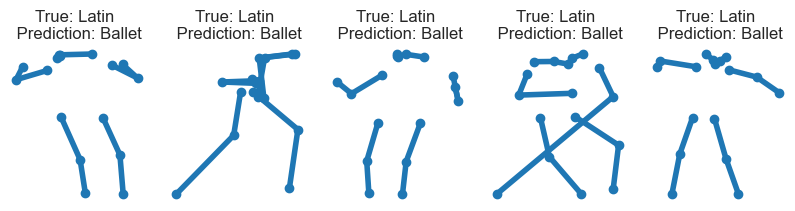

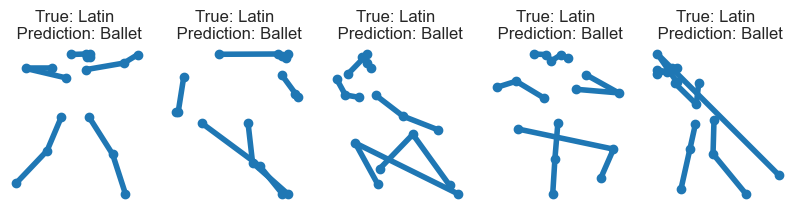

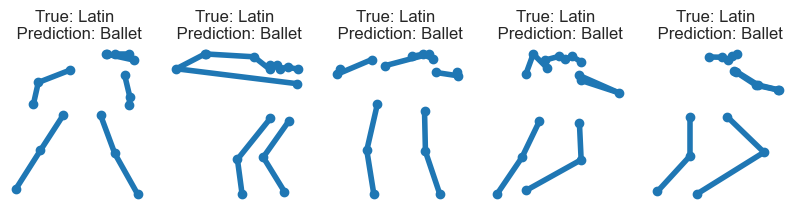

In [24]:
for i in range(10):
    plot_sample_frames(frame_indexes = latin_to_ballet_index[5*i : 5*i+5], file_list = test_files, true_label = 'Latin', pred_label = 'Ballet', figsize = (10,2))

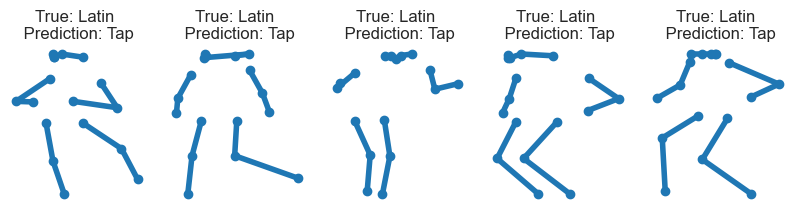

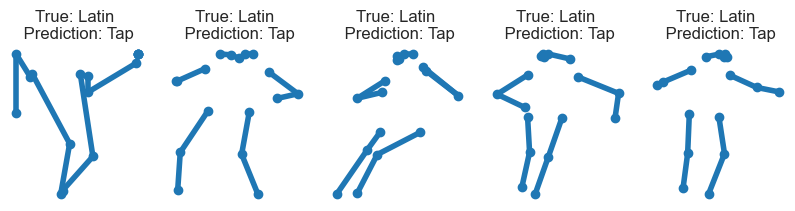

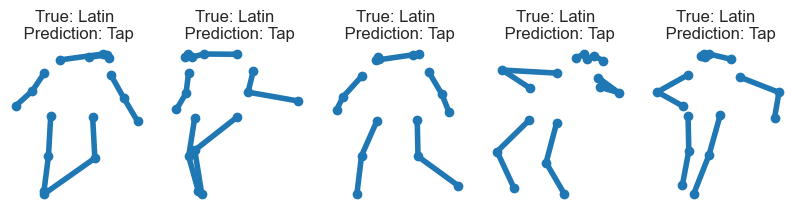

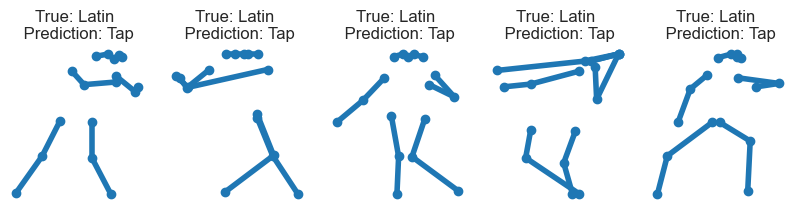

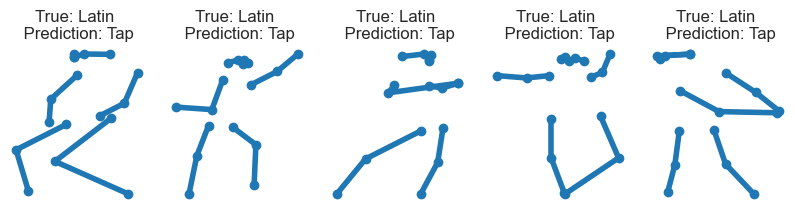

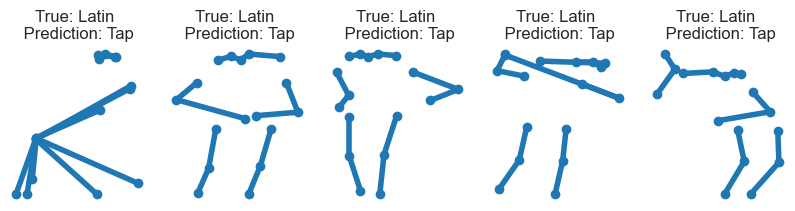

In [25]:
for i in range(6):
    plot_sample_frames(frame_indexes = latin_to_tap_index[5*i : 5*i+5], file_list = test_files, true_label = 'Latin', pred_label = 'Tap', figsize = (10,2))

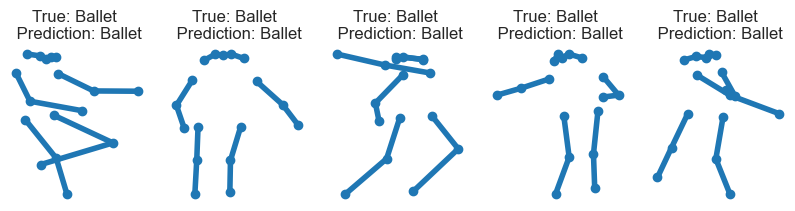

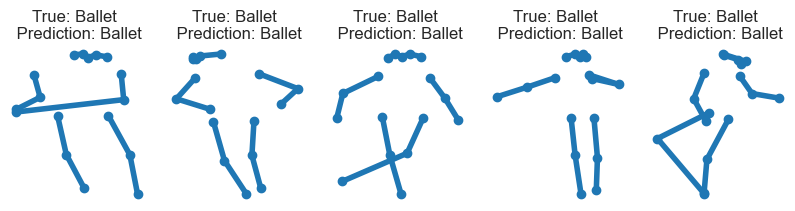

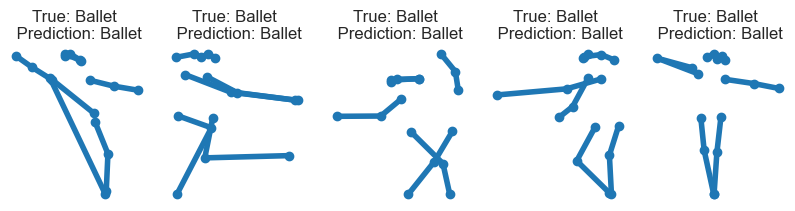

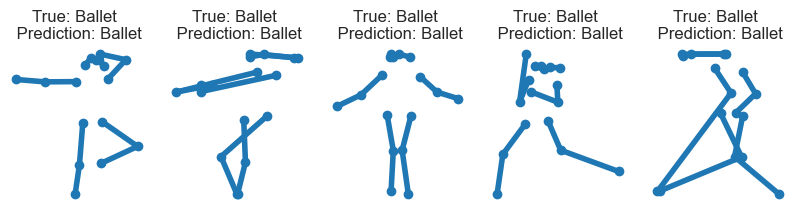

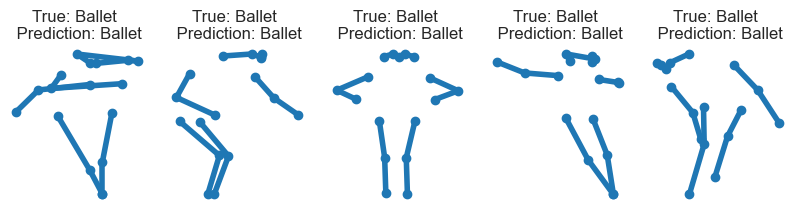

In [26]:
for i in range(5):
    plot_sample_frames(frame_indexes = ballet_to_ballet_index[5*i : 5*i+5], file_list = test_files, true_label = 'Ballet', pred_label = 'Ballet', figsize = (10,2))

## Try NN Models

Build the model and setup the evaluation

Note: Code adapted from HW6

In [169]:
#Preprocess the y data to be integers instead of strings
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)
print(f'encoded y train data is: {y_train_encoded}')

#Collect label names
label_names = list(label_encoder.classes_)

encoded y train data is: [1 0 2 ... 0 0 1]


In [170]:
def build_model(n_classes,
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='SGD',
                learning_rate=0.01):
  """Build a multi-class logistic regression model using Keras.

  Args:
    n_classes: Number of output classes in the dataset.
    hidden_layer_sizes: A list with the number of units in each hidden layer.
    activation: The activation function to use for the hidden layers.
    optimizer: The optimizer to use (SGD, Adam).
    learning_rate: The desired learning rate for the optimizer.

  Returns:
    model: A tf.keras model (graph).
  """
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)

  # YOUR CODE HERE
  #initialize the model
  model = tf.keras.Sequential()

  #Add layer to flatten the image into a vector
  #model.add(keras.layers.Flatten())

  #Add hidden layers to the model
  for hidden_layer_size in hidden_layer_sizes:
    model.add(tf.keras.layers.Dense(units=hidden_layer_size,
                                    activation = activation))
                        
  #Add logistic regression at the end of the model
  model.add(tf.keras.layers.Dense(units=n_classes,
                                  activation = 'softmax'))

  #Select the proper optimizer
  if optimizer == 'Adam':
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = learning_rate)
  else:
    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate = learning_rate)
                            
  #Set the loss and optimizer in the model
  model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer = optimizer,
                metrics=['accuracy'])
  
  return model

In [171]:
def train_and_evaluate(X_train, y_train,
                       n_classes,
                       data='digits',
                       hidden_layer_sizes=[],
                       activation='tanh',
                       optimizer='Adam',
                       learning_rate=0.01,
                       num_epochs=5,
                       exp_number = 0):

  # Build the model.
  model = build_model(n_classes=n_classes,
                      hidden_layer_sizes=hidden_layer_sizes,
                      activation=activation,
                      optimizer=optimizer,
                      learning_rate=learning_rate)

  # Train the model.
  print('Training...')
  history = model.fit(
    x=X_train,
    y=y_train,
    epochs=num_epochs,
    batch_size=64,
    validation_split=0.1,
    verbose=0)

  # Retrieve the training metrics (after each train epoch) and the final test
  # accuracy.
  train_accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  plt.plot(train_accuracy, label='train_accuracy_' + str(exp_number))
  plt.plot(val_accuracy, label='validation accuracy_' + str(exp_number))
  plt.xticks(range(num_epochs))
  plt.xlabel('Train epochs')
  plt.legend()
  
  return train_accuracy, val_accuracy, plt.gcf(), model



Training...


<function matplotlib.pyplot.show(close=None, block=None)>

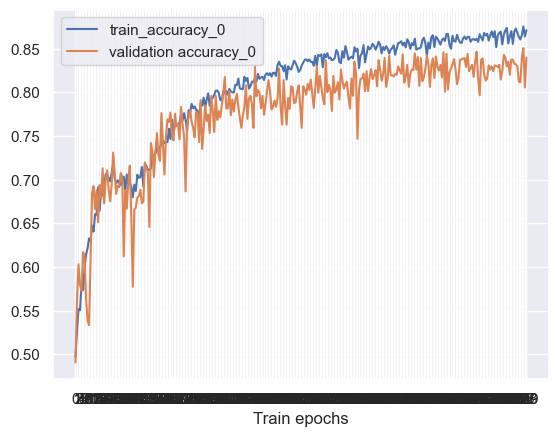

In [30]:
# Run the model
train_accuracy, val_accuracy, fig, model = train_and_evaluate(X_train = X_train_flattened_reshaped, y_train = y_train_encoded, 
                                                       n_classes = 3, hidden_layer_sizes = [256,128], activation = 'relu', 
                                                       optimizer = 'Adam', num_epochs = 300, learning_rate = 0.001)

plt.show

Training...


<function matplotlib.pyplot.show(close=None, block=None)>

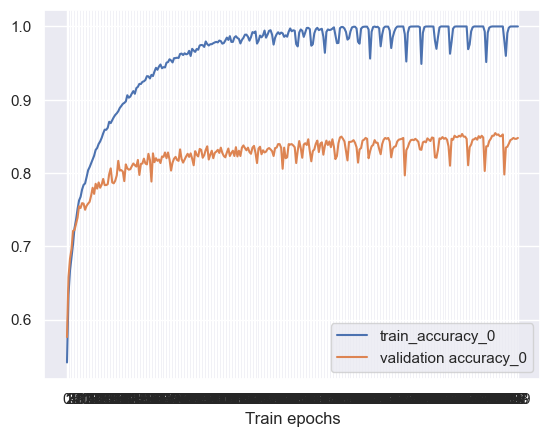

In [172]:
# Run the model
train_accuracy, val_accuracy, fig, model = train_and_evaluate(X_train = X_train_normalized_flattened, y_train = y_train_encoded, 
                                                       n_classes = 3, hidden_layer_sizes = [256,128], activation = 'relu', 
                                                       optimizer = 'Adam', num_epochs = 300, learning_rate = 0.001)

plt.show

In [31]:
#Predict outcome for training data
softmax_output = model.predict(X_train_flattened_reshaped)
y_pred_encoded = np.argmax(softmax_output, axis=1)

520/520 [==============================] - 0s 281us/step


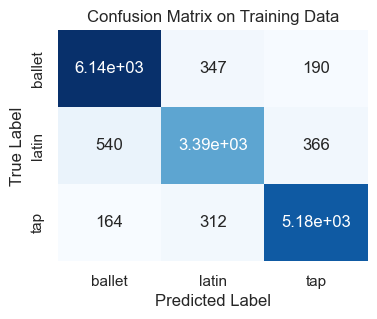

In [32]:
# Create confusion matrix on the training data
confusion_matrix = tf.math.confusion_matrix(y_train_encoded, y_pred_encoded)

# Use a heatmap plot to display it.
plt.figure(figsize=(4, 3))
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=label_names, yticklabels=label_names, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
ax.set_title('Confusion Matrix on Training Data')
plt.show()

In [33]:
#Evaluate the accuracy on test data
softmax_output = model.predict(X_test_flattened_reshaped)
predicted_indices = np.argmax(softmax_output, axis=1)

# Convert the encoded integers back into strings
predicted_labels = label_encoder.inverse_transform(predicted_indices)

#Calculate the accuracy score for the test data
accuracy = accuracy_score(y_test, predicted_labels)
print(f'accuracy on the test data is: {accuracy}')                       

130/130 [==============================] - 0s 311us/step
accuracy on the test data is: 0.8417127736348328


## Try K-Nearest Neighbor Model

In [34]:
n_neighbors_list = [1,3,5,10,20,50]
accuracies = []

for n_neighbors in n_neighbors_list:
    #Set up the model and evaluate
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train_flattened_reshaped, y_train_encoded)

    # Convert the encoded integers back into strings
    predicted_indices = model.predict(X_test_flattened_reshaped)
    predicted_labels = label_encoder.inverse_transform(predicted_indices)

    #Calculate the accuracy score for the test data
    accuracy = accuracy_score(y_test, predicted_labels)
    accuracies.append(accuracy)
    print(f'accuracy on the test data is: {accuracy}')  

accuracy on the test data is: 0.9557373105605004
accuracy on the test data is: 0.9360115467885495
accuracy on the test data is: 0.9143613182583594
accuracy on the test data is: 0.8883810440221314
accuracy on the test data is: 0.8595140726485446
accuracy on the test data is: 0.8073129660813086


Text(0.5, 0, 'Number of nearest neighbors included')

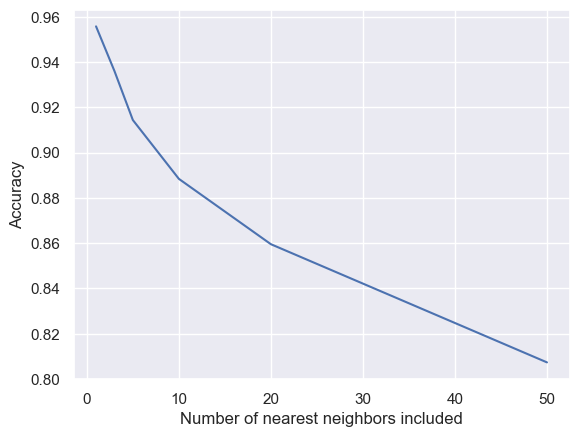

In [35]:
plt.plot(n_neighbors_list, accuracies)
plt.ylabel('Accuracy')
plt.xlabel('Number of nearest neighbors included')

Note: The more nearest neighbors you include in the model, the worse the performance.  Consistent with our thoughts, perhaps the model is just putting images that look almost identical next to each other.  When you include too many potential options, the performance gets worse

Need to confirm by doing treat/train split based on videos instead of frames

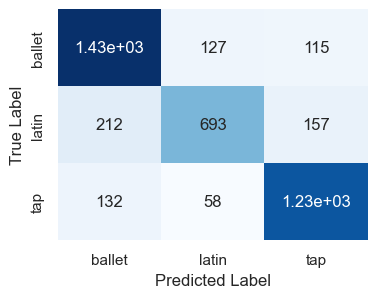

In [36]:
# Create a confusion matrix as a 2D array.
#Need to convert the string y results into integers
confusion_matrix = tf.math.confusion_matrix(label_encoder.fit_transform(y_test), label_encoder.fit_transform(predicted_labels))

# Use a heatmap plot to display it.
plt.figure(figsize=(4, 3))
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=label_names, yticklabels=label_names, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

Across all the models, the biggest error is calling the true label `latin` as `ballet`.  Commonly, the models also call `latin` as `tap`.